In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import bayesnet as bn

np.random.seed(1234)

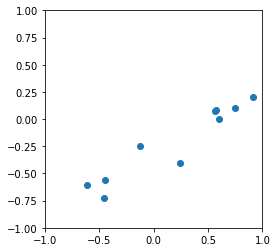

In [2]:
x_train = np.random.uniform(-1, 1, 10)
y_train = 0.5 * x_train - 0.3 + np.random.normal(scale=0.1, size=x_train.shape)
X_train = PolynomialFeatures(degree=1).fit_transform(x_train[:, None])

plt.scatter(x_train, y_train)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")

In [3]:
class BayesianRegressor(bn.Network):
    
    def __init__(self, w=np.zeros(2)):
        super().__init__(w=w)

    def __call__(self, x, y=None):
        self.w_prior = bn.random.MultivariateGaussian(np.zeros(2), np.eye(2), data=self.w)
        self.y = bn.random.MultivariateGaussian((x * self.w).sum(axis=-1), 0.1 * np.eye(x.shape[0]), data=y)
        if y is None:
            return self.y.mu.value

In [4]:
sample = bn.sampler.metropolis(
    BayesianRegressor(np.array([-0.3, 0.5])),
    (X_train, y_train),
    100,
    downsample=10,
    w=bn.random.Gaussian(np.zeros(2), 0.1)
)

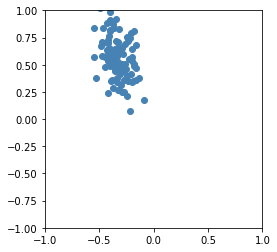

In [5]:
for w in sample["w"]:
    plt.scatter(w[0], w[1], c="steelblue")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal")

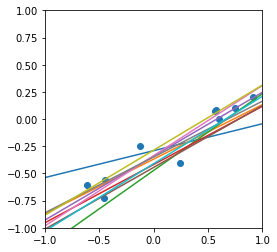

In [6]:
plt.scatter(x_train, y_train)

x = np.linspace(-1, 1, 100)
X = PolynomialFeatures(1).fit_transform(x[:, None])
for i, w in enumerate(sample["w"]):
    if i % 10 == 0:
        model = BayesianRegressor(w)
        plt.plot(x, model(X))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")

In [27]:
sample = bn.sampler.hmc(
    BayesianRegressor(np.array([-0.3, 0.5])),
    (X_train, y_train),
    100, 0.001, 10
)

1.38094344621 -0.330006590945 0.330706094618 -0.315076920373 0.6385433463
[ 0.04547052  0.81200038] [-0.29337277  0.49618237] [-0.14077378  1.12128027] [-0.29376277  0.50666061]
1.87410186328 -0.315076920373 0.294076357092 -0.298099428513 0.905228403646
[-0.35900529  0.67769308] [-0.29376277  0.50666061] [-0.7012085   1.14837426] [-0.29947275  0.51658014]
1.34906627098 -0.298099428513 0.00668035882798 -0.293104227921 0.301097860262
[-0.09564735 -0.06490225] [-0.29947275  0.51658014] [-0.55642127  0.5409169 ] [-0.30297484  0.51908627]
2.99329910008 -0.293104227921 0.884006790422 -0.293181630669 1.98046035025
[-1.32940682  0.02628834] [-0.30297484  0.51908627] [-1.83640882  0.76715276] [-0.32042096  0.52332584]
1.1039107242 -0.305065324301 0.284439622765 -0.293747196772 0.371980574057
[ 0.65857945 -0.36763073] [-0.32699901  0.52151615] [ 0.49133709  0.70890692] [-0.32083825  0.52324543]
2.74541730885 -0.293747196772 0.182948016474 -0.292756955248 1.19189086344
[-0.57063982  0.20066447] [

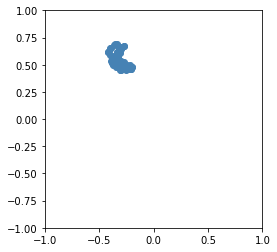

In [28]:
for w in sample["w"]:
    plt.scatter(w[0], w[1], c="steelblue")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal")

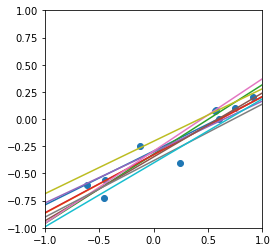

In [29]:
plt.scatter(x_train, y_train)

x = np.linspace(-1, 1, 100)
X = PolynomialFeatures(1).fit_transform(x[:, None])
for i, w in enumerate(sample["w"]):
    if i % 10 == 0:
        model = BayesianRegressor(w)
        plt.plot(x, model(X))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")

In [10]:
model = BayesianRegressor()
optimizer = bn.optimizer.Adam(model, 0.01)
for _ in range(1000):
    model.cleargrad()
    model(X_train, y_train)
    model.log_pdf().backward()
    optimizer.update()

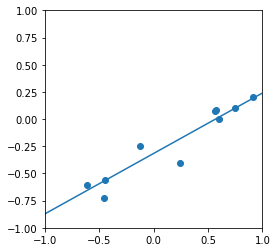

In [11]:
x = np.linspace(-1, 1, 100)
X = PolynomialFeatures(1).fit_transform(x[:, None])
plt.plot(x, model(X))
plt.scatter(x_train, y_train)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")

In [12]:
model.w.value

array([-0.31589654,  0.55566581])